<a href="https://colab.research.google.com/github/mingyu1021/AI-class/blob/main/10week/LSTM_HumanActivity.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import pandas as pd
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt
import seaborn as sns

def load_file(filepath):
    dataframe = pd.read_csv(filepath, header=None, delim_whitespace=True)
    return dataframe.values

# load a list of files and return as a 3d numpy array
def load_group(filenames, prefix=''):
    loaded = list()
    for name in filenames:
        data = load_file(prefix + name)
        loaded.append(data)
    # stack group so that features are the 3rd dimension
    loaded = np.dstack(loaded)
    return loaded

# load a dataset group, such as train or test
def load_dataset_group(group, prefix=''):
    filepath = prefix + group + '/Inertial Signals/'
    # load all 9 files as a single array
    filenames = list()
    # total acceleration
    filenames += ['total_acc_x_'+group+'.txt', 'total_acc_y_'+group+'.txt', 'total_acc_z_'+group+'.txt']
    # body acceleration
    filenames += ['body_acc_x_'+group+'.txt', 'body_acc_y_'+group+'.txt', 'body_acc_z_'+group+'.txt']
    # body gyroscope
    filenames += ['body_gyro_x_'+group+'.txt', 'body_gyro_y_'+group+'.txt', 'body_gyro_z_'+group+'.txt']
    # load input data
    X = load_group(filenames, filepath)
    # load class output
    y = load_file(prefix + group + '/y_'+group+'.txt')
    return X, y


# load the dataset, returns train and test X and y elements
def load_dataset(prefix=''):
    # load all train
    trainX, trainy = load_dataset_group('train', prefix + '/content/drive/MyDrive/AI-class/UCI HAR Dataset/')
    # load all test
    testX, testy = load_dataset_group('test', prefix + '/content/drive/MyDrive/AI-class/UCI HAR Dataset/')

    #zero-offset class values
    trainy = trainy - 1
    testy = testy - 1
    #one hot encode y
    trainy_one_hot = to_categorical(trainy)
    testy_one_hot = to_categorical(testy)
    print(trainX.shape, trainy.shape, trainy_one_hot.shape, testX.shape, testy.shape, testy_one_hot.shape)
    return trainX, trainy, trainy_one_hot, testX, testy, testy_one_hot

trainX, trainy, trainy_one_hot, testX, testy, testy_one_hot = load_dataset()

from sklearn.model_selection import train_test_split

X_train,X_val,y_train_one_hot,y_val_one_hot,y_train,y_val=train_test_split(trainX, trainy_one_hot, trainy,test_size=0.2,random_state=100)

X_train.shape,X_val.shape,y_train_one_hot.shape,y_val_one_hot.shape,y_train.shape,y_val.shape

/tmp/ipython-input-388696316.py:8: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  dataframe = pd.read_csv(filepath, header=None, delim_whitespace=True)
/tmp/ipython-input-388696316.py:8: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  dataframe = pd.read_csv(filepath, header=None, delim_whitespace=True)
/tmp/ipython-input-388696316.py:8: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  dataframe = pd.read_csv(filepath, header=None, delim_whitespace=True)
/tmp/ipython-input-388696316.py:8: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  dataframe = pd.read_csv(filepath, header=None, delim_whitespace=True)
/tmp

(7352, 128, 9) (7352, 1) (7352, 6) (2947, 128, 9) (2947, 1) (2947, 6)


((5881, 128, 9), (1471, 128, 9), (5881, 6), (1471, 6), (5881, 1), (1471, 1))

In [3]:
n_timesteps, n_features, n_outputs = X_train.shape[1], X_train.shape[2], y_train_one_hot.shape[1]


In [4]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (
    Input, Dense, Flatten, Dropout,
    Conv1D, MaxPooling1D, LSTM, concatenate  # LSTM을 import 리스트에 추가
)
from tensorflow.keras.utils import to_categorical

## 1. 입력 레이어
# CNN과 동일하게 (128, 9) 형태의 입력을 정의합니다.
main_input = Input(shape=(n_timesteps, n_features))

## 2. LSTM 레이어
# 첫 번째 LSTM 레이어: units=128, 다음 층으로 시퀀스 전체를 전달 (return_sequences=True)
lstm_1 = LSTM(units=128, return_sequences=True)(main_input)
# 과적합 방지를 위한 Dropout
drop_1 = Dropout(0.3)(lstm_1)

# 두 번째 LSTM 레이어: units=64, 마지막 타임스텝의 출력(hidden state)만 전달 (return_sequences=False)
lstm_2 = LSTM(units=64, return_sequences=False)(drop_1)
# 과적합 방지를 위한 Dropout
drop_2 = Dropout(0.3)(lstm_2)

## 3. 분류기 (Classifier Head)
# LSTM(return_sequences=False)의 출력은 이미 1D 벡터이므로 Flatten()이 필요 없습니다.
dense_1 = Dense(512, activation='relu')(drop_2)
outputs = Dense(n_outputs, activation='softmax')(dense_1)

## 4. 모델 생성 및 컴파일
# 모델 이름을 cnn3_model 대신 lstm_model로 변경
lstm_model = Model(inputs=main_input, outputs=outputs)

lstm_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
lstm_model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 128, 9)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 128, 128)       │        70,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128, 128)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 64)             │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │        33,280 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 6)              │         3,078 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 156,422 (611.02 KB)

 Trainable params: 156,422 (611.02 KB)

 Non-trainable params: 0 (0.00 B)

In [5]:
# --- Cell 4: 모델 훈련 ---
# 'cnn3_model'을 'lstm_model'로 변경
# 'model_history'를 'lstm_history'로 변경
lstm_history = lstm_model.fit(x=X_train, y=y_train_one_hot, epochs=30, batch_size=32, validation_split=0.1)

Epoch 1/30
166/166 ━━━━━━━━━━━━━━━━━━━━ 8s 16ms/step - accuracy: 0.4600 - loss: 1.2491 - val_accuracy: 0.7623 - val_loss: 0.5454
Epoch 2/30
166/166 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step - accuracy: 0.7231 - loss: 0.6055 - val_accuracy: 0.8693 - val_loss: 0.3413
Epoch 3/30
166/166 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step - accuracy: 0.8844 - loss: 0.3360 - val_accuracy: 0.9389 - val_loss: 0.1720
Epoch 4/30
166/166 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - accuracy: 0.9266 - loss: 0.2216 - val_accuracy: 0.9219 - val_loss: 0.2204
Epoch 5/30
166/166 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - accuracy: 0.9393 - loss: 0.1674 - val_accuracy: 0.9508 - val_loss: 0.1284
Epoch 6/30
166/166 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - accuracy: 0.9468 - loss: 0.1514 - val_accuracy: 0.9423 - val_loss: 0.1231
Epoch 7/30
166/166 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - accuracy: 0.9441 - loss: 0.1503 - val_accuracy: 0.9474 - val_loss: 0.1132
Epoch 8/30
166/166 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - accuracy: 0.9496 - loss: 0.1207 - val_accu

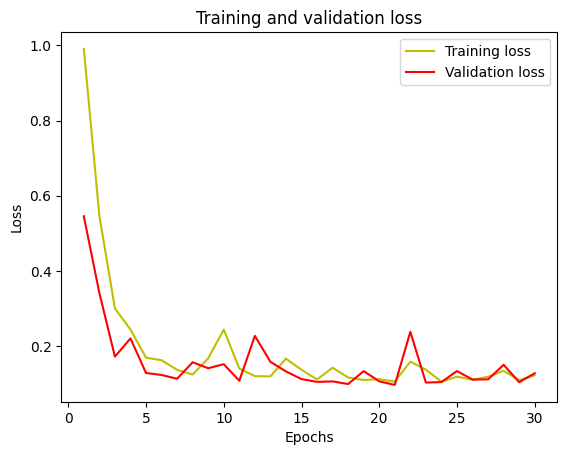

In [6]:
# --- Cell 5: 손실 시각화 ---
import matplotlib.pyplot as plt
import seaborn as sns

# 'model_history'를 'lstm_history'로 변경
loss = lstm_history.history['loss']
val_loss = lstm_history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

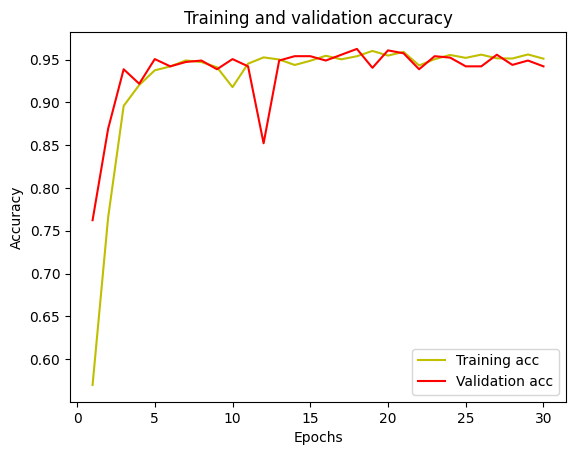

In [7]:
# --- Cell 6: 정확도 시각화 ---
# 'model_history'를 'lstm_history'로 변경
acc = lstm_history.history['accuracy']
val_acc = lstm_history.history['val_accuracy']
plt.plot(epochs, acc, 'y', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step
[[473   0  23   0   0   0]
 [ 28 424  19   0   0   0]
 [ 25   1 394   0   0   0]
 [ 16   2   6 418  47   2]
 [  4   0   0 115 413   0]
 [  0   0   0   0   0 537]]
0.9022734984730234
              precision    recall  f1-score   support

           0       0.87      0.95      0.91       496
           1       0.99      0.90      0.94       471
           2       0.89      0.94      0.91       420
           3       0.78      0.85      0.82       491
           4       0.90      0.78      0.83       532
           5       1.00      1.00      1.00       537

    accuracy                           0.90      2947
   macro avg       0.90      0.90      0.90      2947
weighted avg       0.91      0.90      0.90      2947



<Axes: >

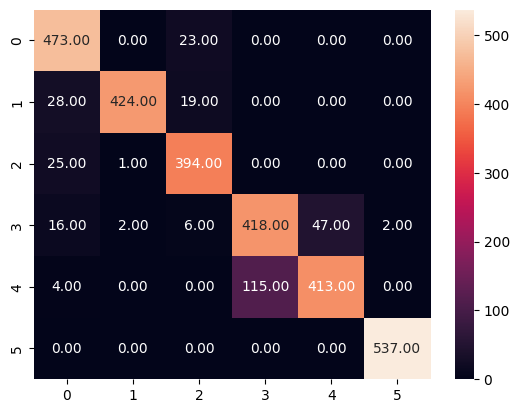

In [8]:
# --- Cell 7: 모델 평가 ---
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

# 'cnn3_model'을 'lstm_model'로 변경
pred = lstm_model.predict(testX)
pred = np.argmax(pred, axis=-1)
cm = confusion_matrix(testy, pred)
print(cm)
print(accuracy_score(testy, pred))
print(classification_report(testy, pred))
sns.heatmap(cm, annot=True, fmt='.2f')